<a href="https://colab.research.google.com/github/greatshotkid/greatshotkid/blob/main/Unobias001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Model 001, using simple bi-directional LSTM**

## Importing dataset from google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing the zip file

In [2]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/My Dataset.zip", 'r')
zip_ref.extractall("/content/dataset")
zip_ref.close()

## **Importing the required libraries**

In [3]:
!pip install PyPDF2
!pip install ftfy
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import PyPDF2
import ftfy
from io import BytesIO
import os
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing.text import Tokenizer
import json
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 3.4 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## **Creating some constarints**

In [4]:
vocab_size = 10000
embedding_dim = 128
max_sequence_length = 1000
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"


In [5]:
# Define the AUC metric outside the tf.function
auc_metric = AUC(name='auc')

METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    # Pass the pre-defined AUC metric here
    auc_metric,
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'),
]

def fresh_metrics():
    return [metric() for metric in METRICS]

## **Extracting text from the pdf CVs**

In [6]:
def extract_text_from_pdf(file_path):
    text = ""
    try:
        with open(file_path, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            for page in reader.pages:
              extracted_text = page.extract_text()
              if extracted_text:
                text += ftfy.fix_text(extracted_text) + "\n"

    except PyPDF2.errors.PdfReadError as e:
        print(f"Error reading PDF file {file_path}: {e}")
        return "" # Return an empty string if an error occurs
    return text


## **Text preprocessing**

In [7]:
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Removing punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    # Tokenization
    words = word_tokenize(text)
    # Removing stop words
    words = [word for word in words if word not in stopwords.words('english')]
    return words

## Importing file paths using os module

In [8]:
# List of file paths
pdf_file_paths = []



# Example: List all files in a directory
directory = '/content/dataset/My Dataset'
pdf_file_paths = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.pdf')]

#for path in pdf_file_paths:
    #print(path)



## Converting text into integers using Tokenize and Vectorize

In [9]:

# Extract and preprocess all CVs
list_of_texts = [preprocess_text(extract_text_from_pdf(file_path)) for file_path in pdf_file_paths] # Call the two functions to extract and preprocess

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(list_of_texts)  # list_of_texts is a list of preprocessed CVs

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(list_of_texts)

/usr/local/lib/python3.10/dist-packages/PyPDF2/_cmap.py:142: PdfReadWarning: Advanced encoding /SymbolSetEncoding not implemented yet
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PyPDF2/_cmap.py:142: PdfReadWarning: Advanced encoding /UniKS-UCS2-H not implemented yet
  warnings.warn(


##Defining the Keywords

In [10]:
# Loading keywords from a target file
with open('/content/drive/MyDrive/ITkeywords.txt', 'r') as file:
    keywords = file.read().splitlines()

# code below used to see if file has been imported
# print(keywords)

##Creating labels for keywords

In [11]:
# Create labels for each CV based on presence of keywords
def create_labels(lists_of_texts, keywords):
    labels = []
    for text in lists_of_texts:
        label = [1 if keyword in text else 0 for keyword in keywords]
        labels.append(label)
    return labels

##Creating labels and adding padding

In [24]:
#creating labels for each CV based on presence of keywords
labels = create_labels(list_of_texts, keywords)

# Pad sequences
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Inspect padded_sequences
print("Unique values in padded_sequences:", np.unique(padded_sequences))

# Replace None or special padding tokens (if present) with 0
# Assuming the padding token is None, adjust if it's different
padded_sequences[padded_sequences == None] = 0


Unique values in padded_sequences: [   0    1    2 ... 9997 9998 9999]


## Creating training, testing and validation sets

In [14]:
 # Split the data into training (80%) and testing (20%) sets
 X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

 # Split the training set into training (75%) and validation (25%) sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


print("Shape of X_train:", X_train.shape)
print("First few samples of X_train:", X_train[:2])
print(len(X_train))

Shape of X_train: (2091, 1000)
First few samples of X_train: [[   0    0    0 ...   64  137 2061]
 [   0    0    0 ...   12  297 3888]]
2091


## Building the model

In [15]:
model_1 = Sequential([
    Embedding(vocab_size, embedding_dim),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(len(keywords), activation='sigmoid')
])

model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

##Handling None values in X_val

In [22]:
# Handle None values in X_val (replace with 0 for example)
X_val = np.nan_to_num(X_val, nan=0.0)

# Check if handling worked
if np.any(np.isnan(X_val)):
    print("X_val still contains None values.")
else:
    print("X_val does not contain None values.")


X_val does not contain None values.


##Compiling, training and saving the model

In [34]:
#Compiling the model
model_1.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=0.001),
    metrics = METRICS
)

# Convert X_train, X_val, y_train, y_val to numpy arrays if they aren't already
X_train = np.asarray(X_train, dtype=np.float32)
X_val = np.asarray(X_val, dtype=np.float32)
X_test = np.asarray(X_test, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.float32) # Convert y_train to NumPy array
y_val = np.asarray(y_val, dtype=np.float32)   # Convert y_val to NumPy array
y_test = np.asarray(y_test, dtype=np.float32) # Convert y_test to NumPy array
# Check and potentially adjust the batch size to be consistent
batch_size = 17  # Or a smaller value if memory is an issue
if X_train.shape[0] % batch_size != 0 or X_val.shape[0] % batch_size != 0:
    print("Warning: Batch size does not divide evenly into the number of samples. Consider adjusting the batch size.")

#Training the model
history_model_1 = model_1.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = 10,

)

#Saving the model
model_1.save('model_1.keras')
with open('history_model_1.json', 'w') as f:
    json.dump(history_model_1.history, f)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 171ms/step - accuracy: 0.9809 - auc: 0.9723 - fn: 2228.8059 - fp: 327.7164 - loss: 0.0513 - precision: 0.7740 - recall: 0.3322 - tn: 130019.5703 - tp: 1112.0597 - val_accuracy: 0.9799 - val_auc: 0.9652 - val_fn: 1471.0000 - val_fp: 251.0000 - val_loss: 0.0530 - val_precision: 0.6514 - val_recall: 0.2418 - val_tn: 83663.0000 - val_tp: 469.0000
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9802 - auc: 0.9728 - fn: 2259.1194 - fp: 342.1045 - loss: 0.0516 - precision: 0.7605 - recall: 0.3224 - tn: 129995.7734 - tp: 1091.1493 - val_accuracy: 0.9800 - val_auc: 0.9640 - val_fn: 1363.0000 - val_fp: 355.0000 - val_loss: 0.0525 - val_precision: 0.6191 - val_recall: 0.2974 - val_tn: 83559.0000 - val_tp: 577.0000
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 0.9805 - auc: 0.9746 - fn: 2129.3879 - fp: 434.0895 - loss: 0.0514 - precision: 0.7466 - recall: 0.3845 - tn: 129807.2812 - tp: 1317.3881 - val_accuracy: 0.9804 -

##Plotting the training history

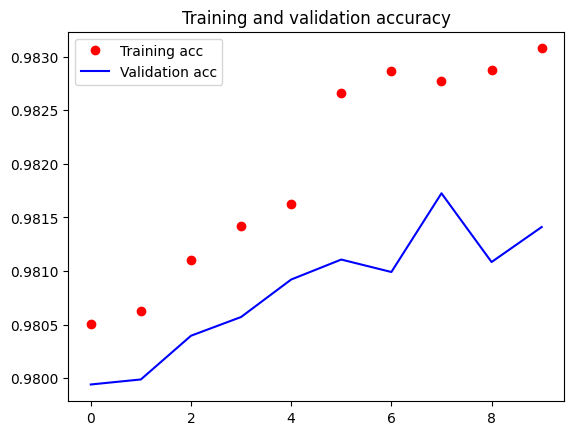

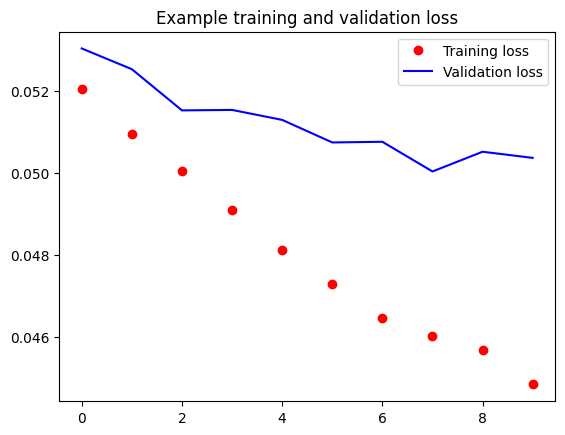

In [35]:
acc = history_model_1.history['accuracy']
val_acc = history_model_1.history['val_accuracy']
loss = history_model_1.history['loss']
val_loss = history_model_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Example training and validation loss')
plt.legend()

plt.show()

## Evaluating model_1

In [36]:
model_1.evaluate(X_test, y_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9805 - auc: 0.9646 - fn: 728.6957 - fp: 187.0870 - loss: 0.0543 - precision: 0.7083 - recall: 0.3853 - tn: 45608.3477 - tp: 472.5652


[0.054526254534721375,
 0.9804902672767639,
 0.7269790172576904,
 0.40232452750205994,
 0.9670177698135376,
 900.0,
 338.0,
 83279.0,
 1337.0]